In [95]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import norm
import pandas as pd
import itertools
from scipy.stats import dirichlet
import import_ipynb
from team_model import predict_fixtures, import_fixture_lists, import_fixture_list

In [96]:
# create form matrix
def find_form(fixtures_list):
    
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    mat_form = np.zeros((N, 2))
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        mat_form[i, 0] = form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht]
        mat_form[i, 1] = form[team_count[ind_for_season_at].astype(int), ind_for_season_at]
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    
    return(teams_for_season, mat_form)

### Optimization of players

#### Probability functions of points scoring

In [97]:
def sample_clean_sheet_for_team(lambda_2):
    return(np.random.poisson(lambda_2) == 0)

def sample_mins_played(a, b, a_games, b_games):
    return(np.random.choice([1, 0], 1, p=np.random.dirichlet([a_games, b_games]))[0] * np.min([np.random.poisson(np.random.gamma(a, 1 / b)), 90]))

def sample_goals_and_assists(a, b, c, n, mins_played):
    t_goals = np.random.uniform(0, 90, n)  # times of goals
    n_goals = np.sum(t_goals <= mins_played)
    d = np.random.dirichlet(np.array([a, b, c]))  # sample hyperparameters
    if (n_goals > 0):
        samples = np.random.choice(np.array([0, 1, 2]), n_goals, p=d)
        return(sum(samples == 0), sum(samples == 1))
    else:
        return(0, 0)

def sample_clean_sheet_points(goals_conceded, mins_played):
    return(int(mins_played > 60) * int(goals_conceded == 0))

def sample_mins_points(mins_played):
    return(int(mins_played > 60) + int(mins_played >= 1))

In [98]:
def get_players(all_players_params, team_sel):
    ind = all_players_params.index[all_players_params['team'] == team_sel]
    return(ind)

In [133]:
def ComputeExpectedPoints(fixtures_list, teams, all_players_params, all_teams_params,
                          zerooutbottom=0, Niter=250, additionalstats=False, form=None):
    
    # param data sets are pd Data Frames
    
    # Without bonus for now and goals conceded points
    
    # preallocate points for each iteration
    points = np.zeros((Niter, len(all_players_params.index)))
    clean_sheets = np.zeros((Niter, len(all_players_params.index)))
    goals_scored = np.zeros((Niter, len(all_players_params.index)))
    mplayed = np.zeros((Niter, len(all_players_params.index)))

    # mean and std of team hyperparameters
    mu = (all_teams_params.as_matrix())[0, :]
    a = (all_teams_params.as_matrix())[1:(len(teams) + 1), :]
    d = (all_teams_params.as_matrix())[(len(teams) + 1):((2 * len(teams)) + 1), :]
    alpha = (all_teams_params.as_matrix())[((2 * len(teams)) + 1), :]

    for l in range(Niter):
        
        # preallocate form array
        team_points = np.zeros((38, len(teams)))
        team_counter = np.zeros(len(teams))
        
        for i in range(np.shape(fixtures_list)[0]):
            
            # find teams for each fixture
            h_team = fixtures_list[i, 0]
            a_team = fixtures_list[i, 1]
            
            # compute form
            if hasattr(form, '__len__'):
                form_h = form[i, 0]
                form_a = form[i, 1]
            else:
                if team_counter[np.where(h_team == teams)[0][0]] > 5:
                    form_h = (np.cumsum(team_points[:, int(np.where(h_team == teams)[0][0])])[5:] - np.cumsum(team_points[:, int(np.where(h_team == teams)[0][0])])[:(38 - 5)])[int(team_counter[np.where(h_team == teams)[0][0]] - 1 - 5)]
                else:
                    form_h = 7.5
                if team_counter[np.where(a_team == teams)[0][0]] > 5:
                    form_a = (np.cumsum(team_points[:, int(np.where(a_team == teams)[0][0])])[5:] - np.cumsum(team_points[:, int(np.where(a_team == teams)[0][0])])[:(38 - 5)])[int(team_counter[np.where(a_team == teams)[0][0]] - 1 - 5)]
                else:
                    form_a = 7.5
            
            # sample lambdas for team performance - sample from team hyperparameters
            lambdas = predict_fixtures(np.reshape(fixtures_list[i, :2], ((1, 2))),
                                       np.reshape(np.array([form_h, form_a]), ((1, 2))),
                                       teams, mu, a, d, alpha, uncertainty=True)
            
            # sample score
            h_n = np.random.poisson(lambdas[0][0])
            a_n = np.random.poisson(lambdas[1][0])
            
            # compute incremental team points
            team_points[int(team_counter[np.where(h_team == teams)[0][0]]),
                        int(np.where(h_team == teams)[0][0])] += (3 * (h_n > a_n)) + (h_n == a_n)
            team_points[int(team_counter[np.where(a_team == teams)[0][0]]),
                        int(np.where(a_team == teams)[0][0])] += (3 * (h_n < a_n)) + (h_n == a_n)
            
            team_counter[np.where(h_team == teams)[0][0]] += 1
            team_counter[np.where(a_team == teams)[0][0]] += 1
            
            # find all players in these teams
            h_players = get_players(all_players_params, h_team)
            a_players = get_players(all_players_params, a_team)
            
            # loop over players
            for j in range(len(h_players)):
                
                # predefine scalings for points
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[h_players[j]], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                
                # sample mins played
                mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[h_players[j]], 'a_mins'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'b_mins'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'a_games'],
                                                 all_players_params.loc[all_players_params.index[h_players[j]], 'b_games'])
                
                goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[h_players[j]], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[h_players[j]], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[h_players[j]], 'c_goals'],
                                                         h_n, mins_played)
                points[l, h_players[j]] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                csp = sample_clean_sheet_points(a_n, mins_played)
                points[l, h_players[j]] += ((scaling[2] * csp) +
                                            (sample_mins_points(mins_played)))
                clean_sheets[l, h_players[j]] += csp
                goals_scored[l, h_players[j]] += goa
                mplayed[l, h_players[j]] += mins_played
            
            for j in range(len(a_players)):
                
                # predefine scalings for points
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[a_players[j]], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                
                # sample mins played
                mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[a_players[j]], 'a_mins'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'b_mins'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'a_games'],
                                                 all_players_params.loc[all_players_params.index[a_players[j]], 'b_games'])
                
                goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[a_players[j]], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[a_players[j]], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[a_players[j]], 'c_goals'],
                                                         a_n, mins_played)
                points[l, a_players[j]] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                csp = sample_clean_sheet_points(h_n, mins_played)
                points[l, a_players[j]] += ((scaling[2] * csp) +
                                            (sample_mins_points(mins_played)))
                clean_sheets[l, a_players[j]] += csp
                goals_scored[l, a_players[j]] += goa
                mplayed[l, a_players[j]] += mins_played

        print('---')
        print('Realisation ', l)
        print('Top Points Scorers: ', all_players_params.loc[all_players_params.index[np.argsort(points[l, :])[-5:].astype(int)], 'player'],
              ' with ', np.sort(points[l, :])[-5:], ' points')

    if zerooutbottom > 0:
        for l in range(Niter):
            points[l, np.argsort(points[l, :])[:zerooutbottom]] = 0  # to account for bench players when simulating team performance

    expected_points = np.mean(points, axis=0)
    sd_points = np.std(points, axis=0)
    cs = np.mean(clean_sheets, axis=0)
    gs = np.mean(goals_scored, axis=0)
    mp = np.mean(mplayed, axis=0)

    if additionalstats:
        return(expected_points, sd_points, cs, gs, mp)
    else:
        return(expected_points, sd_points)

### Historical fitting

In [129]:
form = np.ones((380, 2)) * 7.5

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

In [130]:
# fixture list this season to predict
fixture_list_this_season = (pd.read_csv("../data/prem_results_20192020.csv", header=None)).values

In [131]:
# small fixture list - use for optimization for any particular gameweek
#fixture_list_this_season = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_season)

#type in current form here
#form=....

In [132]:
C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_this_season, teams, all_players_params, all_teams_params, Niter=200,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


---
380.0
Realisation  0
Top Points Scorers:  516    Christian Eriksen
329      Raheem Sterling
522           Harry Kane
306           Sadio Mané
310        Mohamed Salah
Name: player, dtype: object  with  [198. 198. 200. 204. 241.]  points


In [104]:
# add expected points and std to data frame
all_players_params['Expected Points 2019/2020'] = C
all_players_params['Std Points 2019/2020'] = S
all_players_params['Lower 95% Confidence Points 2019/2020'] = np.fmax(0, C - (2 * S))
all_players_params['Upper 95% Confidence Points 2019/2020'] = C + (2 * S)
all_players_params['Expected Goals 2019/2020'] = G
all_players_params['Expected Clean Sheets 2019/2020'] = CS
all_players_params['Expected Minutes Played 2019/2020'] = MP

In [105]:
# save to csv
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frameref = frame[['player', 'position', 'team', 'Expected Points 2019/2020',
                  'Std Points 2019/2020', 'Lower 95% Confidence Points 2019/2020',
                  'Upper 95% Confidence Points 2019/2020', 'Expected Goals 2019/2020', 'Expected Clean Sheets 2019/2020',
                  'Expected Minutes Played 2019/2020']]
frameref.to_csv("../data/pre_draft_expected_points_20192020.csv")

In [106]:
# extract best current players
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,31.6,38.7,3,Mohamed Salah,MID,Liverpool,229.056,27.082187,174.891626,283.220374,21.704,14.976,2947.760
329,329,28.2,14.9,2205.2,4.2,13.6,28.2,43.4,3,Raheem Sterling,MID,Man City,191.720,22.471173,146.777655,236.662345,14.336,15.104,2576.736
134,134,30.2,12.6,2229.1,2.2,10.3,30.2,28.0,3,Eden Hazard,MID,Chelsea,171.248,22.902456,125.443088,217.052912,11.864,12.096,2605.728
306,306,28.2,15.0,2239.7,4.2,4.9,28.2,43.7,3,Sadio Mané,MID,Liverpool,166.128,21.898302,122.331397,209.924603,14.528,13.360,2613.432
128,128,31.4,2.1,2745.0,1.0,5.8,31.4,48.8,3,César Azpilicueta,DEF,Chelsea,158.448,17.880249,122.687502,194.208498,2.216,13.280,3111.200
828,828,20.0,3.0,1615.5,1.0,4.5,20.0,22.5,3,Matt Doherty,DEF,Wolves,154.712,18.075316,118.561368,190.862632,3.800,10.584,2886.624
516,516,29.6,8.3,2395.4,2.8,10.0,29.6,35.9,3,Christian Eriksen,MID,Tottenham,154.672,20.385790,113.900421,195.443579,8.384,13.080,2791.664
522,522,26.6,18.2,2178.7,5.8,4.6,26.6,26.4,3,Harry Kane,FWD,Tottenham,152.944,20.775102,111.393796,194.494204,19.120,11.616,2507.008
130,130,26.4,4.1,2281.0,6.0,5.6,26.4,39.1,3,Marcos Alonso,DEF,Chelsea,150.992,23.030587,104.930826,197.053174,4.400,11.384,2611.568
322,322,31.3,1.0,2713.5,1.1,1.5,31.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,148.600,14.500759,119.598483,177.601517,0.664,17.120,3099.824


In [107]:
# extract best current goalkeepers
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'GKP'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
322,322,31.3,1.0,2713.5,1.1,1.5,31.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,148.600,14.500759,119.598483,177.601517,0.664,17.120,3099.824
772,772,20.5,1.0,1755.0,0.5,1.0,20.5,94.5,3,Alisson Ramses Becker,GKP,Liverpool,141.976,13.940711,114.094578,169.857422,0.808,15.184,3099.400
775,775,20.0,1.0,1755.0,1.0,1.0,20.0,82.5,3,David de Gea,GKP,Man United,128.688,15.290476,98.107048,159.268952,0.640,12.512,3083.672
710,710,19.5,1.0,1665.0,1.5,1.0,19.5,80.0,3,Kepa Arrizabalaga,GKP,Chelsea,128.320,12.897504,102.524993,154.115007,0.672,12.872,2952.792
506,506,28.3,1.0,2502.0,4.1,1.0,28.3,99.1,3,Hugo Lloris,GKP,Tottenham,121.040,13.985936,93.068128,149.011872,0.568,12.408,2815.456
196,196,32.2,1.0,2781.0,0.2,1.0,32.2,90.7,3,Jordan Pickford,GKP,Everton,120.352,12.071955,96.208090,144.495910,0.496,9.968,3178.312
844,844,19.5,1.0,1710.0,1.5,1.0,19.5,72.5,3,Rui Pedro dos Santos Patrício,GKP,Wolves,117.464,11.441359,94.581281,140.346719,0.640,10.416,2976.968
474,474,31.7,1.0,2781.0,0.7,1.0,31.7,85.1,3,Lukasz Fabianski,GKP,West Ham,110.192,11.590131,87.011738,133.372262,0.568,7.752,3175.848
259,259,30.2,1.0,2644.5,2.2,1.0,30.2,87.8,3,Kasper Schmeichel,GKP,Leicester,109.008,13.046070,82.915860,135.100140,0.464,8.552,2993.912
578,578,31.4,1.0,2754.0,1.0,1.0,31.4,85.4,3,Ben Foster,GKP,Watford,108.832,11.032125,86.767751,130.896249,0.480,7.712,3131.664


In [108]:
# extract best current defenders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'DEF'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
128,128,31.4,2.1,2745.0,1.0,5.8,31.4,48.8,3,César Azpilicueta,DEF,Chelsea,158.448,17.880249,122.687502,194.208498,2.216,13.280,3111.200
828,828,20.0,3.0,1615.5,1.0,4.5,20.0,22.5,3,Matt Doherty,DEF,Wolves,154.712,18.075316,118.561368,190.862632,3.800,10.584,2886.624
130,130,26.4,4.1,2281.0,6.0,5.6,26.4,39.1,3,Marcos Alonso,DEF,Chelsea,150.992,23.030587,104.930826,197.053174,4.400,11.384,2611.568
315,315,27.8,3.0,2412.9,4.6,3.0,27.8,60.5,3,Virgil van Dijk,DEF,Liverpool,147.400,17.590907,112.218187,182.581813,3.192,13.536,2770.760
341,341,27.9,1.5,2268.2,4.5,3.3,27.9,70.2,3,Kyle Walker,DEF,Man City,143.472,17.963775,107.544450,179.399550,1.360,15.208,2646.952
316,316,26.4,1.3,2235.0,6.0,8.5,26.4,53.9,3,Andrew Robertson,DEF,Liverpool,143.176,18.538636,106.098728,180.253272,1.376,12.544,2558.888
826,826,19.5,3.0,1629.0,1.5,1.0,19.5,25.5,3,Willy Boly,DEF,Wolves,139.584,17.996526,103.590948,175.577052,3.880,10.432,2894.424
721,721,19.0,3.0,1527.0,2.0,3.5,19.0,26.0,3,Lucas Digne,DEF,Everton,139.136,18.394497,102.347007,175.924993,3.576,8.976,2735.936
763,763,18.5,2.0,1606.5,2.5,5.0,18.5,22.5,3,Ricardo Domingos Barbosa Pereira,DEF,Leicester,134.032,18.196235,97.639530,170.424470,2.736,7.856,2822.800
833,833,20.0,1.0,1755.0,1.0,1.0,20.0,28.0,3,Conor Coady,DEF,Wolves,129.544,13.280665,102.982670,156.105330,1.536,10.800,3081.304


In [109]:
# extract best current midfielders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'MID'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,31.6,38.7,3,Mohamed Salah,MID,Liverpool,229.056,27.082187,174.891626,283.220374,21.704,14.976,2947.760
329,329,28.2,14.9,2205.2,4.2,13.6,28.2,43.4,3,Raheem Sterling,MID,Man City,191.720,22.471173,146.777655,236.662345,14.336,15.104,2576.736
134,134,30.2,12.6,2229.1,2.2,10.3,30.2,28.0,3,Eden Hazard,MID,Chelsea,171.248,22.902456,125.443088,217.052912,11.864,12.096,2605.728
306,306,28.2,15.0,2239.7,4.2,4.9,28.2,43.7,3,Sadio Mané,MID,Liverpool,166.128,21.898302,122.331397,209.924603,14.528,13.360,2613.432
516,516,29.6,8.3,2395.4,2.8,10.0,29.6,35.9,3,Christian Eriksen,MID,Tottenham,154.672,20.385790,113.900421,195.443579,8.384,13.080,2791.664
175,175,30.8,10.0,2678.7,1.6,2.6,30.8,27.0,3,Luka Milivojevic,MID,Crystal Palace,145.536,18.458405,108.619191,182.452809,11.248,8.344,3043.344
372,372,27.4,9.3,2192.0,5.0,9.9,27.4,31.0,3,Paul Pogba,MID,Man United,144.456,20.697248,103.061505,185.850495,8.440,10.984,2550.304
817,817,19.5,5.5,1567.5,1.5,4.0,19.5,18.5,3,Felipe Anderson Pereira Gomes,MID,West Ham,137.136,19.211390,98.713220,175.558780,8.496,7.192,2819.208
220,220,28.1,8.7,2283.1,4.3,5.2,28.1,24.6,3,Gylfi Sigurdsson,MID,Everton,136.640,19.702751,97.234498,176.045502,9.000,8.792,2648.904
563,563,29.9,9.0,2221.1,2.5,4.9,29.9,26.2,3,Richarlison de Andrade,MID,Everton,132.560,19.518770,93.522459,171.597541,8.600,8.640,2583.016


In [110]:
# extract best current forwards
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'FWD'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020,Expected Goals 2019/2020,Expected Clean Sheets 2019/2020,Expected Minutes Played 2019/2020
522,522,26.6,18.2,2178.7,5.8,4.6,26.6,26.4,3,Harry Kane,FWD,Tottenham,152.944,20.775102,111.393796,194.494204,19.120,11.616,2507.008
840,840,20.0,7.5,1601.0,1.0,6.0,20.0,12.5,3,Raúl Jiménez,FWD,Wolves,147.168,20.689219,105.789562,188.546438,11.776,10.616,2867.832
339,339,25.0,17.8,1861.5,7.4,8.3,25.0,37.3,3,Sergio Agüero,FWD,Man City,143.792,24.197288,95.397424,192.186576,16.104,12.912,2147.984
276,276,29.9,16.0,2382.4,2.5,4.1,29.9,20.7,3,Jamie Vardy,FWD,Leicester,141.640,17.136347,107.367305,175.912695,14.960,8.248,2785.552
311,311,29.6,11.5,2176.0,2.8,7.4,29.6,47.5,3,Roberto Firmino,FWD,Liverpool,128.712,18.234392,92.243216,165.180784,10.048,13.448,2562.592
169,169,27.2,8.7,2328.2,5.2,8.6,27.2,18.4,3,Wilfried Zaha,FWD,Crystal Palace,125.968,17.282100,91.403800,160.532200,9.016,7.400,2645.320
22,22,28.9,11.7,1952.6,3.5,8.5,28.9,32.3,3,Alexandre Lacazette,FWD,Arsenal,123.112,18.557679,85.996642,160.227358,9.936,6.872,2290.624
31,31,22.9,15.0,1722.8,9.5,5.7,22.9,21.9,3,Pierre-Emerick Aubameyang,FWD,Arsenal,122.208,20.825099,80.557803,163.858197,13.432,6.464,2006.208
53,53,25.2,10.4,1903.3,7.2,7.6,25.2,18.0,3,Callum Wilson,FWD,Bournemouth,118.896,19.644775,79.606450,158.185550,9.600,5.352,2260.552
592,592,28.3,8.6,2175.0,4.1,5.9,28.3,16.1,3,Salomón Rondón,FWD,Newcastle,117.456,16.470339,84.515322,150.396678,8.448,9.296,2536.176


### Analysis of previous season - model verification

In [86]:
# create fixture list this season to predict
fixture_list_last_season = pd.read_csv("../data/prem_results_20182019.csv", header=None).as_matrix()

teams_this_season, form = find_form(fixture_list_last_season)

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_last_season, teams, all_players_params, all_teams_params, Niter=50,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed i

---
Realisation  0
Top Points Scorers:  175       Luka Milivojevic
22     Alexandre Lacazette
339          Sergio Agüero
310          Mohamed Salah
329        Raheem Sterling
Name: player, dtype: object  with  [181. 192. 193. 222. 264.]  points
---
Realisation  1
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
817       Felipe Anderson Pereira Gomes
276                         Jamie Vardy
310                       Mohamed Salah
329                     Raheem Sterling
Name: player, dtype: object  with  [179. 185. 196. 239. 252.]  points
---
Realisation  2
Top Points Scorers:  329        Raheem Sterling
22     Alexandre Lacazette
517          Bamidele Alli
516      Christian Eriksen
310          Mohamed Salah
Name: player, dtype: object  with  [170. 178. 183. 188. 213.]  points
---
Realisation  3
Top Points Scorers:  516      Christian Eriksen
167    Patrick van Aanholt
329        Raheem Sterling
306             Sadio Mané
310          Mohamed Salah
Name: player, dtype: obje

---
Realisation  35
Top Points Scorers:  516    Christian Eriksen
276          Jamie Vardy
329      Raheem Sterling
828         Matt Doherty
310        Mohamed Salah
Name: player, dtype: object  with  [177. 181. 182. 192. 272.]  points
---
Realisation  36
Top Points Scorers:  721        Lucas Digne
339      Sergio Agüero
522         Harry Kane
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [175. 177. 178. 213. 228.]  points
---
Realisation  37
Top Points Scorers:  306           Sadio Mané
128    César Azpilicueta
310        Mohamed Salah
134          Eden Hazard
329      Raheem Sterling
Name: player, dtype: object  with  [192. 194. 215. 219. 225.]  points
---
Realisation  38
Top Points Scorers:  306         Sadio Mané
828       Matt Doherty
372         Paul Pogba
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [165. 172. 172. 229. 230.]  points
---
Realisation  39
Top Points Scorers:  372         Paul Pogba
329    Rahee

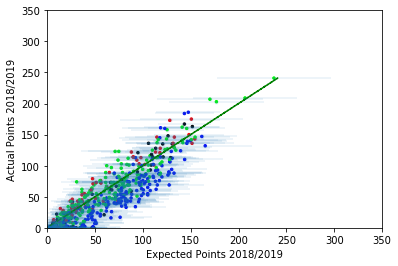

In [87]:
# plot with respect to last seasons points - for those players eligible
y3 = pd.read_csv("../data/players_raw_20182019.csv")
y3['full_name'] = (y3['first_name'] + ' ' + y3['second_name'])
exp_points = np.zeros(len(y3.index))
sd_points = np.zeros(len(y3.index))
cr = np.zeros((len(y3.index), 3))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    exp_points[i] = C[ind]
    sd_points[i] = S[ind]
    cr[i, :] = np.array([((all_players_params.loc[all_players_params.index[ind], 'position'] == 'FWD')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'MID')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'DEF'))])

plot.errorbar(exp_points, y3['total_points'] - y3['bonus'], xerr=2 * sd_points, marker='.', linestyle="", alpha=0.1)
plot.scatter(exp_points, y3['total_points'] - y3['bonus'], color=cr, s=6)
plot.plot(y3['total_points'] - y3['bonus'], y3['total_points'] - y3['bonus'], linestyle="--", color='g')
plot.xlim([0, 350])
plot.ylim([0, 350])
plot.xlabel('Expected Points 2018/2019')
plot.ylabel('Actual Points 2018/2019')
plot.show()

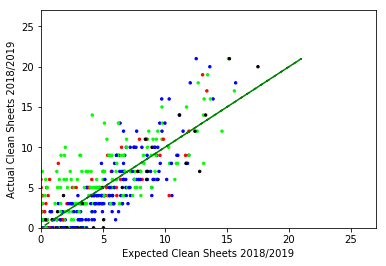

In [88]:
# plot with respect to last seasons clean sheets - for eligble players
clean_sheets = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    clean_sheets[i] = CS[ind]

plot.scatter(clean_sheets, y3['clean_sheets'], color=cr, s=6)
plot.plot(y3['clean_sheets'], y3['clean_sheets'], linestyle="--", color='g')
plot.xlim([0, 27])
plot.ylim([0, 27])
plot.xlabel('Expected Clean Sheets 2018/2019')
plot.ylabel('Actual Clean Sheets 2018/2019')
plot.show()

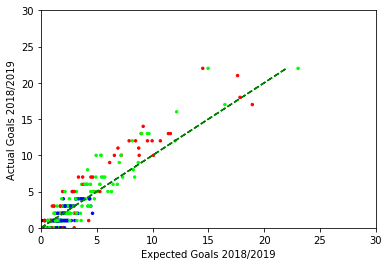

In [89]:
# plot with respect to last seasons goals - for eligble players
goals = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    goals[i] = G[ind]

plot.scatter(goals, y3['goals_scored'], color=cr, s=6)
plot.plot(y3['goals_scored'], y3['goals_scored'], linestyle="--", color='g')
plot.xlim([0, 30])
plot.ylim([0, 30])
plot.xlabel('Expected Goals 2018/2019')
plot.ylabel('Actual Goals 2018/2019')
plot.show()

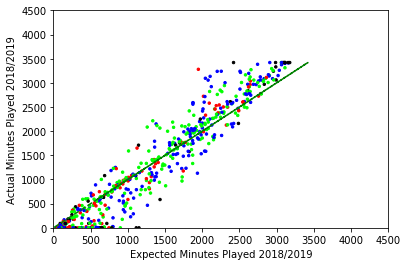

In [90]:
# plot with respect to last seasons mins played - for eligble players
mins_played = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    mins_played[i] = MP[ind]

plot.scatter(mins_played, y3['minutes'], s=6, color=cr)
plot.plot(y3['minutes'], y3['minutes'], linestyle="--", color='g')
plot.xlim([0, 4500])
plot.ylim([0, 4500])
plot.xlabel('Expected Minutes Played 2018/2019')
plot.ylabel('Actual Minutes Played 2018/2019')
plot.show()

### Team predictions

Gives predictions for a team's score on a gameweek

In [58]:
# this gameweek fixtures
#fixture_list_this_gw = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_gw)

# this gameweek form for each fixture
#form =...

# players for a specific team
tm_players = ['Mohamed Salah', 'James Milner'] #....
new_players_frame = all_players_params[all_players_params['player'].isin(tm_players)]
Niter = 100
C, S = ComputeExpectedPoints(fixture_list_this_gw, teams, new_players_frame, all_teams_params,
                             zerooutbottom=3, Niter=Niter, form=form)  # zero out bench players
expected_tm_score = np.sum(C)
sd_tm_score = np.sqrt(np.sum(S ** 2))
print('expected team score: ', expected_tm_score)
print('lower 95% confidence team score: ', max(0, expected_tm_score - (2 * sd_tm_score)))
print('upper 95% confidence team score: ', expected_tm_score + (2 * sd_tm_score))

---
Realisation  0
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 2.]  points
---
Realisation  1
Top Points Scorers:  310    Mohamed Salah
298     James Milner
Name: player, dtype: object  with  [2. 5.]  points
---
Realisation  2
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  3
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [ 4. 10.]  points
---
Realisation  4
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [2. 3.]  points
---
Realisation  5
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 3.]  points
---
Realisation  6
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  7
Top Points Scorers:  298     James Milner
310   

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
# calculates match probability
def match_prob(exp_p1, sd_p1, exp_p2, sd_p2):
    exp_diff = exp_p1 - exp_p2
    sd_diff = np.sqrt((sd_p1 ** 2) + (sd_p2 ** 2))
    return(1 - norm.cdf(0, exp_diff, sd_diff))